#Project for CS235
Name: Fengchun Fan\
 SID: 862134815

#Prepare the Dataset

We will be using the Wisconsin Breast Cancer Diagnostic dataset from the UCI data repository: \
https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

Install the ucimlrepo package

In [ ]:
pip install ucimlrepo

Import the dataset into our code

In [ ]:
from ucimlrepo import fetch_ucirepo

In [ ]:
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

Some testings to ensure dataset is properly imported

In [ ]:
# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

In [ ]:
# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'published_in': 'Electronic imaging', 'year': 1993, 'url': 'https://www.semanticscholar.org/paper/53

In [ ]:
# variable information
print(breast_cancer_wisconsin_diagnostic.variables)

                  name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuous        None        

Get the list of features

In [ ]:
features_df = breast_cancer_wisconsin_diagnostic.variables[breast_cancer_wisconsin_diagnostic.variables['role'] == 'Feature']
feature_list = features_df['name'].tolist()
feature_list

['radius1',
 'texture1',
 'perimeter1',
 'area1',
 'smoothness1',
 'compactness1',
 'concavity1',
 'concave_points1',
 'symmetry1',
 'fractal_dimension1',
 'radius2',
 'texture2',
 'perimeter2',
 'area2',
 'smoothness2',
 'compactness2',
 'concavity2',
 'concave_points2',
 'symmetry2',
 'fractal_dimension2',
 'radius3',
 'texture3',
 'perimeter3',
 'area3',
 'smoothness3',
 'compactness3',
 'concavity3',
 'concave_points3',
 'symmetry3',
 'fractal_dimension3']

Get the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Phase 1 - Supervised Techniques [50/100]


##1. Implementing simple classifiers [15pts]

###Cross Validation and graph

Ploting a bar chart that shows the performance of my classifiers\
As required, we should measure the average +/- standard deviation of the F1 score calculated using stratified 10-fold cross-validation\
I cannot fit my models into the existing sklearn model, so I will try build up my own in reference to: https://medium.com/@avijit.bhattacharjee1996/implementing-k-fold-cross-validation-from-scratch-in-python-ae413b41c80d and https://scikit-learn.org/stable/modules/cross_validation.html\
High level idea is simply:\
We will be using existing function/library to calculate f1 scores and fold/split data. Determine which classifier we will be testing and the number of folds we target. Split the data, and for each fold, get the list of actual labels and predicted labels from classifier (implemented function), transfrom the lists to integers for f1 score calculation function, and store the final result. Lastly, we can just call existing np mean and np std function to find the performance of our classifier.

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# need to preprocess the labels to be integers
from sklearn.metrics import f1_score
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# as required, we need to be using StratifiedKFold
from sklearn.model_selection import StratifiedKFold

class CrossValidation:
  # couple things we need to make sure:
  # which classifier we will be testing on
  # many splits/folds needs in the original data
  # and an array of f1_scores, length should be the same as folding number/splits
  def __init__(self, mode = None, splits = None, SVD = False, rank = None, feat_select = False, feat_index = None):
    self.mode = mode
    self.splits = splits
    self.f1_scores = None
    # used for SVD mode only
    self.SVD = SVD
    self.rank = rank
    # used for feature selection mode only
    self.feat_select = feat_select
    self.feat_index = feat_index
    self.f1_scores_mutate = None

  # function to get the f1 score
  def get_f1_scores(self, X, y):
    # check which classifier we will be testing on
    if(self.mode == "DT"):
      classifier = DecisionTree()
    if(self.mode == "NB"):
      classifier = NaiveBayes()
    # split the input data based on input splits number
    # we didn't enable shuffle thus our results should be the same each time
    # spliter = StratifiedKFold(n_splits = self.splits, shuffle = True, random_state = 10)
    spliter = StratifiedKFold(n_splits = self.splits, shuffle = True, random_state = 42)
    # a list to store the f1 scores
    f1_scores = []
    # a list to store the f1_feature_mutated scores
    f1_scores_mutate = []
    # reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
    # for each fold
    for _, (train_index, test_index) in enumerate(spliter.split(X, y)):
      # split the training and testing dataset
      # chatgpt helped on me this, initially I directly used X[train_index] and cannot work
      if (self.feat_select == True):
        # make a copy of X
        X_mutate = X.copy()
        # randomly permutate the column corresponding to current feature_index
        X_mutate = self.random_permutation(X_mutate)
        X_test_mutate, X_train_mutate = X_mutate.iloc[train_index], X_mutate.iloc[test_index]
        # in feature selection, our training/test amount should be reversed
        # say for 5 fold, we should use 20% training data and 80% testing data
        X_test, X_train = X.iloc[train_index], X.iloc[test_index]
        y_test, y_train = y.iloc[train_index], y.iloc[test_index]
      else:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      print("size check: X_train: ", X_train.shape, " y_train: ", y_train.shape, " X_test: ", X_test.shape, " y_test: ", y_test.shape)

      # for SVD, we need to extract matrix
      if(self.SVD == True):
        print("Evaluating using approximated data of rank: ", self.rank)
        n_samples, n_features = X_train.shape
        # apply SVD to extract matrixes on the training dataset
        U, S, V = svd(X_train, full_matrices=False)
        # rank will be from 1 to 30
        # if rank is 30, then we don't change anything from data
        if self.rank != 30:
          # else, we will prune everything after S[rank], ex. rank == 28, prune S[28] and S[29] to 0
          S[self.rank:] = 0
        S_new = np.diag(S)
        # compose the matrixes back to form the new training dataset
        X_train_new = np.dot(U, np.dot(S_new, V))
        # right now X_train_new is an np array, we need to match the structure of our original X_train
        # which is in pandas Dataframe
        X_train_new = pd.DataFrame(X_train_new)

      # check if the classifier is correctly assigned
      if(classifier != None):
        # fit the trainning data into classifier
        if(self.SVD == True):
          # SVD, we will be using approximated dataset
          classifier.fit(X_train_new, y_train)
        else:
          classifier.fit(X_train, y_train)
        # get the predicted label list and actual label list
        predicted_labels = classifier.get_predicted_labels(X_test, y_test)
        actual_labels = classifier.get_true_labels(X_test, y_test)
        # f1 score will only take in integers, so we need to preprocess the two label lists
        # doesn't really matter which is which
        predicted_labels = [0 if label == 'B' else 1 for label in predicted_labels]
        actual_labels = [0 if label == 'B' else 1 for label in actual_labels]
        # get the current f1 score using f1 calculating function
        score = f1_score(predicted_labels, actual_labels)
        f1_scores.append(score)
        print("current f1 score: ", score)

        # if feat_select is True, then we need to do one additional calculation of f1_scores
        # based on our mutated dataset
        # training of second model
        if self.feat_select == True:
          classifier.fit(X_train_mutate, y_train)
          # get the predicted label list and actual label list
          predicted_labels = classifier.get_predicted_labels(X_test_mutate, y_test)
          actual_labels = classifier.get_true_labels(X_test_mutate, y_test)
          # f1 score will only take in integers, so we need to preprocess the two label lists
          # doesn't really matter which is which
          predicted_labels = [0 if label == 'B' else 1 for label in predicted_labels]
          actual_labels = [0 if label == 'B' else 1 for label in actual_labels]
          # get the current f1 score using f1 calculating function
          score = f1_score(predicted_labels, actual_labels)
          f1_scores_mutate.append(score)
          print("current f1 mutate score: ", score)

      # save the f1_scores after all folds are complete
      self.f1_scores = f1_scores
      self.f1_scores_mutate = f1_scores_mutate
    # doesn't have to return anything, this is for my testing purpose
    return f1_scores

  # helper function to get the difference between means
  def get_mean_diff(self):
    return np.mean(self.f1_scores) - np.mean(self.f1_scores_mutate)

  # helper function to get the difference between stds
  def get_std_diff(self):
    return np.std(self.f1_scores) - np.std(self.f1_scores_mutate)

  # helper function to get the mean of f1_scores
  def get_mean(self):
    return np.mean(self.f1_scores)

  # helper function to get the std of f1_scores
  def get_std(self):
    return np.std(self.f1_scores)

  # helper function, using existing np library to randomly mutate the
  # column of feat_index in X_train_mutate
  def random_permutation(self, X_train_mutate):
    feature_index = self.feat_index
    n_samples, n_features = X_train_mutate.shape
    column_val_list = []
    for index in range(n_samples):
      column_val_list.append(X_train_mutate.iloc[index, feature_index])
    # using existing np library to permutate the values in the column
    # reference to: https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html
    # I am assigning extreme numbers to make sure these randomization take affect
    column_val_list = np.random.permutation(100000)
    #column_val_list = np.random.permutation(column_val_list)
    # update the values in the dataset with new column values
    for index in range(n_samples):
      X_train_mutate.iloc[index, feature_index] = column_val_list[index]
    return X_train_mutate

cross validation scores for DT classifier

In [ ]:
CV_DT = CrossValidation("DT", 10)
f1_scores_DT = CV_DT.get_f1_scores(X, y)
f1_scores_DT

size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.9545454545454546
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.8095238095238095
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.8292682926829269
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.8947368421052632
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.975609756097561
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.9500000000000001
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_tes

[0.9545454545454546,
 0.8095238095238095,
 0.8292682926829269,
 0.8947368421052632,
 0.975609756097561,
 0.9500000000000001,
 0.975609756097561,
 0.9500000000000001,
 0.9523809523809523,
 0.888888888888889]

In [ ]:
DT_f1_mean = CV_DT.get_mean()
DT_f1_mean

0.9180563752322417

In [ ]:
DT_f1_std = CV_DT.get_std()
DT_f1_std

0.056773574343277365

cross validation scores for NB classifier

In [ ]:
CV_NB = CrossValidation("NB", 10)
f1_scores_NB = CV_NB.get_f1_scores(X, y)
f1_scores_NB

size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9545454545454546
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9047619047619048
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9523809523809523
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9545454545454545
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9523809523809523
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.7317073170731706
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8500000000000001
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9

[0.9545454545454546,
 0.9047619047619048,
 0.9523809523809523,
 0.9545454545454545,
 0.9523809523809523,
 0.7317073170731706,
 0.8500000000000001,
 0.9,
 0.975609756097561,
 0.9523809523809523]

In [ ]:
NB_f1_mean = CV_NB.get_mean()
NB_f1_mean

0.9128312744166402

In [ ]:
NB_f1_std = CV_NB.get_std()
NB_f1_std

0.070069414004543

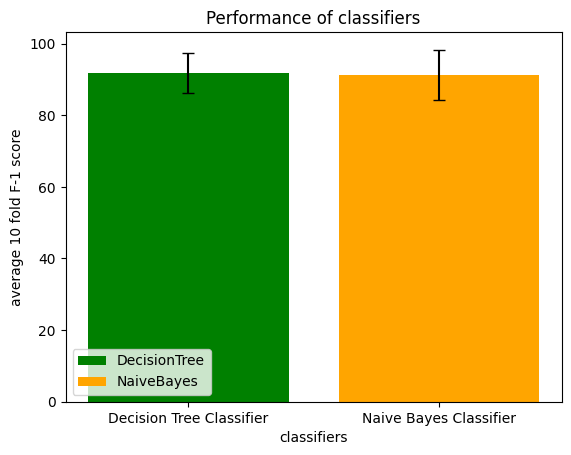

In [ ]:
# plot referenced to: https://www.geeksforgeeks.org/errorbar-graph-in-python-using-matplotlib/, https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
# x_axis = ["Decision Tree Classifier", "Naive Bayes Classifier"]
# y_axis = [DT_f1_mean * 100, NB_f1_mean * 100]
# y_std = [DT_f1_std * 100, NB_f1_std * 100]
plt.bar("Decision Tree Classifier", DT_f1_mean * 100, yerr = DT_f1_std * 100, color = "green", capsize = 4, label = "DecisionTree")
plt.bar("Naive Bayes Classifier", NB_f1_mean * 100, yerr = NB_f1_std * 100, color = "orange", capsize = 4, label = "NaiveBayes")
plt.xlabel("classifiers")
plt.ylabel("average 10 fold F-1 score")
plt.title("Performance of classifiers")
plt.legend()
plt.show()

###decision tree classifier

We will first implement a decision tree classifier that uses the Information Gain splitting criterion (ID3)\
referenced article as inspiration: https://medium.com/@enozeren/building-a-decision-tree-from-scratch-324b9a5ed836 \
High level idea of my code:\
There will be two classes, one for the tree itself and another for tree nodes. Ideally there are two types of nodes, one conditional node (tells you to go right or left) and another leaf node (storing the result label). Thus in a node class we will be needing: feature (easier to be stored as an index), threshold, left child pointer, right child pointer for conditional node usage, and label for leaf node.\
In the main tree class, in order to build the tree we need to do the following. We will be keeping a list of row indexes, they are the data sample available at this current level, the dataset X (features) and y (targets) will serve up as lookup table, thus after every level we are just manipulating indexes stored in the row list, we will not be touching X and y.\
In order to make the best decision of how to split the current dataset, we are basically trying to find best feature/threshold pair. Thus for each level, we will be looping through the feature list, one by one examine them, for each feature, we will loop through the current available data samples, and find all available thresholds (unique numbers appear based on current row/column), we can also just use a median one instead of try all of them, but this way it can make sure we are not missing anything. Then we will split the dataset with current chosen feature/threshold into two datasets, one for left (<=) and one for right (>), calculate its information gain by having the entropy of parent minus entropy of two children. We will keep the feature/threshold, and splited datasets for the ones that give us the highest information gain.\
Here are few termination conditions: first we will follow the ones provided in lecture, if one label if remaining dataset, if one feature only in y, or if no samples left to split. And we have extended it a little to, if there is only one sample left, then there is also no need to split, and we will keep counting the current depth of the tree and set a max depth it can go, setting the depth too low will make our classifier low accuracy, but set it too high/or just wait for itself to finish takes too long to process and may cause overfitting. Lastly, if our max information gain is negative, that means the best split we can do is to decrease our performance, which makes no sense, we better just end right here.

Check the dataset we are using\
Table is stored in X and target (Diagnosis result) is stored in y

In [ ]:
X

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
y

,Diagnosis
0,M
1,M
2,M
3,M
4,M
...,...
564,M
565,M
566,M
567,M


Implementaion:

In [ ]:
# class for TreeNodes
class Node():
  def __init__(self, feature_index = None, threshold = None, left_child = None, right_child = None, label = None):
    # some variables needed are:
    # the feature selected for the current node
    # we will only record its corresponding index in the dataset
    self.feature_index = feature_index
    # the cut off percentage for left/right child
    self.threshold = threshold
    # two children, decision tree is like a binary tree
    # point to the left child of the current node
    self.left_child = left_child
    # point to right child of the current node
    self.right_child = right_child

    # for the leaf nodes, store the final label
    self.label = label

In [ ]:
# class for the actual Decision Tree
class DecisionTree():
  def __init__(self, maxDepth = 10, min_sample_size = 1):
    # initialize the root of the tree to None
    self.root = None
    # in this dataset with 30 features, we will try to limit the depth of our tree to 10
    # if depth is too deep, then it may cause overfitting, if it is too little, then it may decrease accuracy
    self.maxDepth = maxDepth
    # min sample size, we don't want to keep spliting if the size is too small
    # saves lots of running time
    self.min_sample_size = min_sample_size

  # main function to be called, input with dataset (X and y)
  # set the root of the decision tree by calling the build tree function
  # in the beginning, of course we will consider all the rows, so we will create a list with all row numbers
  # in my algorithm, X and y serves like a look up table, the selected indexes will be in selected_row list
  def fit(self, X, y):
    n_samples, _ = X.shape
    # 0 ... n_samples - 1
    selected_row = list(range(n_samples))
    self.root = self.build_tree(selected_row, X, y)
    print("finished building the tree")

  # recursively build up the decision tree with given dataset (X and y)
  def build_tree(self, selected_row, X, y, curr_depth = 0):
    # get the number of samples (number of rows) from selected_row
    # and number of features (number of columns) from X
    n_samples = len(selected_row)
    _, n_features = X.shape

    # if selected row only contain one label, then it is a pure node and we do not need to split anymore
    # consider it a leaf node and return
    # corresponding to stopping condition 1: All samples for a given node belong to same class
    if (self.get_num_labels(selected_row, y) == 1):
      leaf_label = self.get_label(selected_row, y)
      return Node(label = leaf_label)

    # if there are no attributes for further partitionings, i.e the number of features is only 1
    # we will consider it a leaf node and return, use majority vote to find the label for current node
    # corresponding to stopping condition 2: There are no remaining attributes for further partitioning
    # in our example, this is likely not going to be used
    if (n_features <= 1):
      leaf_label = self.get_label(selected_row, y)
      return Node(label = leaf_label)

    # if no samples left, we should stop right here, but since there is no samples, the label for our leaf node will be "null"
    # indicate that if you reach here, there is some edge case
    # corresponding to stopping condition 3: There are no samples left
    if (n_samples == 0):
      leaf_label = self.get_label(selected_row, y)
      return Node(label = leaf_label)

    # check if we can further split the tree
    # if so, keep spliting and current node is a condition/internal node
    if(n_samples > self.min_sample_size and curr_depth <= self.maxDepth):
      # find the best split we can get using current indexes (max information gain)
      feature_index, threshold, selected_row_left, selected_row_right, information_gain = self.get_best_split(selected_row, X, y, n_features)
      # if we have positive information gain, then we will proceed to further split, and here is why:
      # if information gain is negative/zero, then that means the best split we can do is giving us no better information, then just don't split
      if information_gain > 0:
        # generate current node's left and right child node by calling the build tree function using left/right child dataset
        left_child = self.build_tree(selected_row_left, X, y, curr_depth + 1)
        right_child = self.build_tree(selected_row_right, X, y, curr_depth + 1)
        return Node(feature_index, threshold, left_child, right_child)


    # if we cannot split the tree any further, that means the current node is a leaf node
    # thus we will determine what is the label of the current node
    # by checking what is the majority label in the corresponding y
    leaf_label = self.get_label(selected_row, y)
    return Node(label = leaf_label)

  # helper function, given the target dataset, calculate the entropy of the current node
  # we will be calling this function inside the target node, we will pass in selected datapoints (portion of X, only contain selected row number)
  # we will loop through X, find its corresponding conditions in y and calculate the entropy from there
  def find_entropy(self, selected_X, y):
    # track the unique labels in our target set
    # reference: https://numpy.org/doc/stable/reference/generated/numpy.unique.html
    unique_labels = np.unique(y)
    entropy = 0
    # for each unique label, find its entropy portion
    # combine the portions together from all labels we will get the entropy for the current node
    for label in unique_labels:
      curr_hit = 0
      # in our dataset, we only have 1 column
      # find the number of points in curr select list that has this current label
      for index in selected_X:
        if(y.iloc[index, 0] == label):
          curr_hit = curr_hit + 1
      # reference: https://www.w3schools.com/python/ref_math_log2.asp
      # and probability need to be a positive number passing into log2
      p_i = (curr_hit) / len(selected_X)
      # using math.log_2, if curr_hit is 0, p_i is 0 and entropy portion is undefined
      # this case, we can just ignore this portion and move on
      if p_i != 0:
        entropy += (-p_i * math.log2(p_i))
    return entropy

  # helper function to get the label for leaf node
  # all we need to do is to count the target label from rows in selected_row
  # and return the label that appear the most times
  def get_label(self, selected_row, y):
    # number of unique labels from y
    unique_labels = np.unique(y)
    max_hit = -float("inf")
    # some edge case happens, typically for error or empty dataset
    selected_label = None
    # record the label that get the most hit
    for label in unique_labels:
      curr_hit = 0
      for index in selected_row:
        # we know that y have only 1 column
        if(y.iloc[index, 0] == label):
          curr_hit = curr_hit + 1
      if curr_hit > max_hit:
        # update max hit
        max_hit = curr_hit
        selected_label = label
    return selected_label

  # helper function, return the number of unique labels among the selected index
  def get_num_labels(self, selected_row, y):
    unique_labels = np.unique(y)
    num_labels = 0
    for label in unique_labels:
      for index in selected_row:
        # we know that y have only 1 column
        if(y.iloc[index, 0] == label):
          num_labels = num_labels + 1
          # move on to next label
          break
    return num_labels

  # helper function, get the best spliting point from current selected row indexes
  # the idea is to use information gain, find the one feature/threshold pair that will give
  # us the most information gain
  # keep the information gain value, selected feature index, threshold value
  # and the partition left dataset (<= threshold) and right dataset (> threshold)
  def get_best_split(self, selected_row, X, y, n_features):
    # a list to store the varaibles we described above
    best_feature_index = None
    best_threshold = None
    best_selected_row_left = None
    best_selected_row_right = None
    max_information_gain = -float("inf")
    # given the current selected_row
    # go through every feature by its index
    for feature_index in range(n_features):
      # find the best threshold for the current data points
      # to find the best threshold, we can need to collect all the values with row: index in selected, col: feature index
      # and we can either do median, or we can try all the unique values
      threshold_list = self.find_threshold(selected_row, X, feature_index)
      # loop through each possible threshold may takes a huge amount of time, thus we will only be accessing median
      # this may decrease the accuracy by a bit, but saves huge amount of time
      threshold = np.median(threshold_list)
      # for threshold in threshold_list:
      # split the current data index based on selected feature_index and threshold value
      # left <=, right >
      selected_row_left, selected_row_right = self.split(feature_index, threshold, X, selected_row)
      # need to make sure that both lists are not empty, else we will encounter divide by zero error in calculating entropy
      # plus, have one split as 0 really has no meanings (pick max threshold value)
      if len(selected_row_left) != 0 and len(selected_row_right) != 0:
        # now, calculate the information gain based on the splited/selected datasets
        info_gain = self.information_gain(selected_row_left, selected_row_right, selected_row, y)
        # we want to only record the information for the split that give us the max information gain
        if info_gain > max_information_gain:
          # update the max info gain
          max_information_gain = info_gain
          best_feature_index = feature_index
          best_threshold = threshold
          best_selected_row_left = selected_row_left
          best_selected_row_right = selected_row_right
    return best_feature_index, best_threshold, best_selected_row_left, best_selected_row_right, max_information_gain

  # helper function for us to find the information
  def information_gain(self, selected_row_left, selected_row_right, selected_row, y):
    info_gain = 0
    # parent entropy
    info_D = self.find_entropy(selected_row, y)
    info_A_D_l = len(selected_row_left)/len(selected_row) * self.find_entropy(selected_row_left, y)
    info_A_D_r = len(selected_row_right)/len(selected_row) * self.find_entropy(selected_row_right, y)
    info_gain = info_D - (info_A_D_l + info_A_D_r)
    return info_gain

  # helper function to split the current data points into left and right part
  # based on its feature index's value against threshold value
  def split(self, feature_index, threshold, X, selected_row):
    selected_row_left = []
    selected_row_right = []
    # loop through the datapoints
    for index in selected_row:
      if(X.iloc[index, feature_index] <= threshold):
        selected_row_left.append(index)
      else:
        selected_row_right.append(index)
    return selected_row_left, selected_row_right

  # helper function to help us find the threshold list
  # we will loop through the X table, record every value with row inside selected_row, and col equals to feature_index
  # then we will return with list with uniqueness processing (no repetition)
  def find_threshold(self, selected_row, X, feature_index):
    threshold_list = []
    for index in selected_row:
      threshold_list.append(X.iloc[index, feature_index])
    threshold_list = np.unique(threshold_list)
    return threshold_list

  # helper function, given a set of test data
  # for each datapoint, loop through the tree until a finding a leaf node, get the label and check its correctness
  # return percentage of matches
  def get_prediction_accuracy(self, X, y):
    n_samples, n_features = X.shape
    num_correct = 0
    # loop through all indexes, get the predicted label and actual label
    # match them for correctness
    for index in range(n_samples):
      predict_label = self.get_predicting_label(X.iloc[index, ], self.root)
      # knowing we only have one column in target set
      actual_label = y.iloc[index, 0]
      #print("index: ", index, " expected: ", actual_label, " got: ", predict_label)
      if predict_label == actual_label:
        num_correct = num_correct + 1
    return num_correct/n_samples

  def get_predicting_label(self, data_point, tree):
    # if we have a actual label, then return that label
    if tree.label != None:
      return tree.label
    # else, we will decide if we can to left child or right child
    # based on data_point's feature index's value compare to threshold
    if data_point.iloc[tree.feature_index] <= tree.threshold:
      return self.get_predicting_label(data_point, tree.left_child)
    else:
      return self.get_predicting_label(data_point, tree.right_child)

  # for cross validation, return all the true labels
  def get_true_labels(self, X, y):
    n_samples, n_features = X.shape
    # count the number of matching case (success prediction)
    true_labels = []
    for index in range(n_samples):
      # actual label of current data point
      actual_label = y.iloc[index, 0]
      true_labels.append(actual_label)
    return true_labels

  # for cross validation, return all the predicted labels
  def get_predicted_labels(self, X, y):
    n_samples, n_features = X.shape
    # count the number of matching case (success prediction)
    predicted_labels = []
    for index in range(n_samples):
      # predicted label of current data point
      predicted_label = self.get_predicting_label(X.iloc[index, ], self.root)
      predicted_labels.append(predicted_label)
    return predicted_labels

Split the training and testing data, we will be using a 70/30 split\
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Build the Tree based on training data

In [ ]:
DT = DecisionTree()

In [ ]:
DT.get_tree(X_train,y_train)

finished building the tree


Input the testing data through the tree to check the accuracy of our decision tree

In [ ]:
accuracy_DT = DT.get_prediction_accuracy(X_test, y_test)
accuracy_DT

0.9181286549707602

####testing area (disregard)

In [ ]:
DT = DecisionTree()

Test on entropy calculation

In [ ]:
row_list = list(range(5))
row_list

[0, 1, 2, 3, 4]

In [ ]:
entropy = DT.find_entropy(row_list,y)
entropy

0.0

helper functions test

In [ ]:
majority_label = DT.get_label(row_list,y)
majority_label

'M'

In [ ]:
num_uni_label = DT.get_num_labels(row_list,y)
num_uni_label

1

In [ ]:
threshold_list = DT.find_threshold(row_list, X, 0)
threshold_list

array([11.42, 17.99, 19.69, 20.29, 20.57])

In [ ]:
selected_row_left, selected_row_right = DT.split(0, 19.69, X, row_list)
selected_row_left, selected_row_right

([0, 2, 3], [1, 4])

###Naive Bayes classifier

We will be implementing a naive bayes classifier\
High level idea of my algorithm:\
Because the dataset we are using, which has continuous features, we need to be applying Naive Bayes with Gaussian distribution on finding conditional probability. That means, we will need prior probability, mean, and standard deviation by all features by label.\
Thus, after passing in the testing datasets, we will first split the data by unique labels. Then, for each feature of each label, we will be finding the mean and standard deviation of all its data point values and store them into a dictionary.\
Now, for each datapoint label we trying to predict, we will find its probability of being each label by applying gaussian distribution (by our store mean/std and its own value per feature), multiple the prior probability with conditional probability of each feature. Whichever label that gives us the highest final probability will be picked.\
Lastly, we need to double check that during our calculation, if there is time that our conditional probability equals to 0, if that is the case, we need to apply Laplacian Correction.

double-check on datasets

In [ ]:
X

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
y

,Diagnosis
0,M
1,M
2,M
3,M
4,M
...,...
564,M
565,M
566,M
567,M


Implementation:

In [ ]:
# class for naive bayes classifier
class NaiveBayes():
  # we will be storing prior probability for labels
  # and we will be storing mean and std distribution for each features by label
  # these will later be pluged into guassian distribution function to find probability of feature value by label
  # they will all be dictionaries ({key: value} pair)
  # all dictionaries stored here will be processed by main function and later used during prediction
  def __init__(self):
    self.prior_prob = None
    self.mean_dict = None
    self.std_dict = None

  # main function, we will input X and y datasets
  # calculate all the prior probabilities, mean and standard deviation that will be needed
  # just like in decision tree, I will use X, y as look up table, and use arrays to store splited data
  # def NaiveBayes_Gaussian(self, X, y):
  def fit(self, X, y):
    # first, we will split the datasets depending on label
    splited_datasets = self.split(X, y)
    # get the prior probability
    self.prior_prob = self.find_prior_prob(y)
    # get mean values
    self.mean_dict = self.find_mean(splited_datasets, X, y)
    # get standard deviations
    self.std_dict = self.find_std(splited_datasets, X, y)

  # helper function to find std
  # we have already splited data based on label
  # now we will get their actual values by feature and calculate its std value
  # dictionary will be saved like: label => feature_index => std value
  def find_std(self, splited_datasets, X, y):
    std_dict = {}
    n_samples, n_features = X.shape
    unique_labels = np.unique(y)
    # loop through labels
    for label in unique_labels:
      # extracted the splited data
      curr_data = splited_datasets[label]
      # create a dictionary to store std value by feature
      std_list_by_feature = {}
      # we will calculate std for each feature in this label
      for feature_index in range(n_features):
        curr_value_list = []
        # push every corresponding value into this list
        for index in curr_data:
          curr_value_list.append(X.iloc[index, feature_index])
        # get the std value of current feature
        # reference: https://numpy.org/doc/stable/reference/generated/numpy.std.html
        std_val = np.std(curr_value_list)
        # key: feature_index, val: std value of all datapoints having this feature and under current label
        std_list_by_feature[feature_index] = std_val
      # key: label, value: dictionary of {feature_index, std_val}
      std_dict[label] = std_list_by_feature
    return std_dict

  # helper function to find mean
  # we have already splited data based on label
  # now we will get their actual values by feature and calculate its mean value
  # dictionary will be saved like: label => feature_index => mean value
  def find_mean(self, splited_datasets, X, y):
    mean_dict = {}
    n_samples, n_features = X.shape
    unique_labels = np.unique(y)
    # loop through labels
    for label in unique_labels:
      # extracted the splited data
      curr_data = splited_datasets[label]
      # create a dictionary to store mean value by feature
      mean_list_by_feature = {}
      # we will calculate mean for each feature in this label
      for feature_index in range(n_features):
        curr_value_list = []
        # push every corresponding value into this list
        for index in curr_data:
          curr_value_list.append(X.iloc[index, feature_index])
        # get the mean value of current feature
        # reference: https://numpy.org/doc/stable/reference/generated/numpy.mean.html
        mean_val = np.mean(curr_value_list)
        # key: feature_index, val: mean value of all datapoints having this feature and under current label
        mean_list_by_feature[feature_index] = mean_val
      # key: label, value: dictionary of {feature_index, mean_val}
      mean_dict[label] = mean_list_by_feature
    return mean_dict

  # helper function to split the dataset
  # idea is simple, we get the unique labels in y, and regroup datapoints in X based on its label
  # thinking back, we probably don't really need X
  def split(self, X, y):
    splited_datasets = {}
    # get number of sample data
    n_samples, _ = X.shape
    unique_labels = np.unique(y)
    # loop through dataset X, and check its label
    for label in unique_labels:
      curr_selection = []
      for index in range(n_samples):
        # we know that y only has 1 column
        if y.iloc[index, 0] == label:
          curr_selection.append(index)
      splited_datasets[label] = curr_selection
    return splited_datasets


  # find the prior_prob giving y dataset
  def find_prior_prob(self, y):
    # get number of rows in y
    n_samples, _ = y.shape
    # empty dictionary
    prior_prob = {}
    unique_labels = np.unique(y)
    # loop through dataset y, count number of datapoints that has current label
    # and store its probability of appearance: its occurance / total number of samples
    for label in unique_labels:
      count = 0
      for index in range(n_samples):
        # we know that y only has 1 column
        if y.iloc[index, 0] == label:
          count = count + 1
      # update probability
      prior_prob[label] = count / n_samples
    return prior_prob

  # helper function, given a set of test data
  # for each datapoint, we will find its probability of being each unique label, and assign the label that has highest probability
  # this can be achieve by applying naive bayes equation
  # the probability of given label and having its value can be found by applying guassian distribution
  # return percentage of matches
  def get_prediction_accuracy(self, X, y):
    n_samples, n_features = X.shape
    # count the number of matching case (success prediction)
    count = 0
    for index in range(n_samples):
      # actual label of current data point
      actual_label = y.iloc[index, 0]
      # predicted label of current data point
      predicted_label = self.get_predicting_label(index, X, y)
      # check if they are a match
      if actual_label == predicted_label:
        count = count + 1
    # successful prediction / total number of samples
    return count / n_samples

  # helper function to find the predicted label of current data point (represented by index)
  def get_predicting_label(self, index, X, y):
    _, n_features = X.shape
    unique_labels = np.unique(y)
    predicted_label = None
    max_probability = -float("inf")
    # find probability for each label
    # store label that has highest probability
    for label_index in range(len(unique_labels)):
      label = unique_labels[label_index]
      # apply gaussian distribution
      curr_probability = self.prior_prob[label]
      # apply probability per feature
      for feature_index in range(n_features):
        curr_mean = self.mean_dict[label][feature_index]
        curr_std = self.std_dict[label][feature_index]
        # calculate conditional probability by applying gaussian distribution
        conditional_probability = (1/(np.sqrt(2*np.pi)*curr_std))*np.exp(-((X.iloc[index,feature_index]-curr_mean)**2/(2*curr_std**2)))
        # check if there is Zero Probability problem, if so, we may need to apply Laplacian correction
        # current it is a easy fix (add a very small number), if I have time, I will later implement a formal fix
        if (conditional_probability == 0):
          conditional_probability += 0.0000001
        curr_probability *= conditional_probability
      # for the final probability, compare with max and update label if needed
      if curr_probability > max_probability:
        max_probability = curr_probability
        # save the index of label itself for cross validation
        predicted_label = label
    return predicted_label

  # for cross validation, return all the true labels
  def get_true_labels(self, X, y):
    n_samples, n_features = X.shape
    # count the number of matching case (success prediction)
    true_labels = []
    for index in range(n_samples):
      # actual label of current data point
      actual_label = y.iloc[index, 0]
      true_labels.append(actual_label)
    return true_labels

  # for cross validation, return all the predicted labels
  def get_predicted_labels(self, X, y):
    n_samples, n_features = X.shape
    # count the number of matching case (success prediction)
    predicted_labels = []
    for index in range(n_samples):
      # predicted label of current data point
      predicted_label = self.get_predicting_label(index, X, y)
      predicted_labels.append(predicted_label)
    return predicted_labels

Split training and testing data in 70/30 fashion

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Train the classifier

In [ ]:
NB = NaiveBayes()
#NB.NaiveBayes_Gaussian(X_train, y_train)
NB.fit(X_train, y_train)

Predict and check accuracy on testing data

In [ ]:
accuracy_NB = NB.get_prediction_accuracy(X_test, y_test)
accuracy_NB

0.9415204678362573

####Testing area (disregard)

In [ ]:
NB = NaiveBayes()

In [ ]:
prior_prob = NB.find_prior_prob(y)
prior_prob

{'B': 0.6274165202108963, 'M': 0.37258347978910367}

In [ ]:
splited_data = NB.split(X, y)
splited_data

{'B': [19,
  20,
  21,
  37,
  46,
  48,
  49,
  50,
  51,
  52,
  55,
  58,
  59,
  60,
  61,
  63,
  66,
  67,
  68,
  69,
  71,
  74,
  76,
  79,
  80,
  81,
  84,
  88,
  89,
  90,
  92,
  93,
  96,
  97,
  98,
  101,
  102,
  103,
  104,
  106,
  107,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  120,
  123,
  124,
  125,
  128,
  130,
  133,
  136,
  137,
  139,
  140,
  142,
  143,
  144,
  145,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  157,
  158,
  159,
  160,
  163,
  165,
  166,
  169,
  170,
  173,
  174,
  175,
  176,
  178,
  179,
  183,
  185,
  187,
  188,
  189,
  191,
  192,
  195,
  200,
  204,
  206,
  208,
  209,
  211,
  216,
  217,
  220,
  221,
  222,
  224,
  225,
  226,
  227,
  228,
  231,
  232,
  234,
  235,
  238,
  240,
  241,
  242,
  243,
  245,
  246,
  247,
  248,
  249,
  251,
  266,
  267,
  268,
  269,
  270,
  271,
  273,
  275,
  276,
  278,
  279,
  281,
  284,
  285,
  286,
  287,
  288,
  289,
  290,
  291,
 

In [ ]:
mean_dict = NB.find_mean(splited_data, X, y)
mean_dict

{'B': {0: 12.146523809523808,
  1: 17.914761904761903,
  2: 78.075406162465,
  3: 462.7901960784313,
  4: 0.09247764705882354,
  5: 0.0800846218487395,
  6: 0.04605762100840336,
  7: 0.025717406162464984,
  8: 0.1741859943977591,
  9: 0.0628673949579832,
  10: 0.28408235294117645,
  11: 1.2203801120448179,
  12: 2.0003212885154062,
  13: 21.135148459383753,
  14: 0.007195901960784313,
  15: 0.02143824649859944,
  16: 0.02599673557422969,
  17: 0.009857652661064425,
  18: 0.020583806722689075,
  19: 0.0036360512605042015,
  20: 13.37980112044818,
  21: 23.51507002801121,
  22: 87.00593837535013,
  23: 558.8994397759103,
  24: 0.12495949579831933,
  25: 0.18267254901960786,
  26: 0.16623772268907563,
  27: 0.07444434453781512,
  28: 0.27024593837535016,
  29: 0.07944207282913165},
 'M': {0: 17.462830188679245,
  1: 21.60490566037736,
  2: 115.36537735849056,
  3: 978.3764150943397,
  4: 0.10289849056603775,
  5: 0.14518778301886792,
  6: 0.16077471698113208,
  7: 0.08799,
  8: 0.19290896

In [ ]:
std_dict = NB.find_std(splited_data, X, y)
std_dict

{'B': {0: 1.7780161836026676,
  1: 3.9895252572260462,
  2: 11.790888955886492,
  3: 134.09890905926835,
  4: 0.013427232082988903,
  5: 0.03370265260130135,
  6: 0.043381265029092966,
  7: 0.015886481551090136,
  8: 0.0247719904837415,
  9: 0.0067378861269878024,
  10: 0.11241183708645963,
  11: 0.588353966870931,
  12: 0.7700883763867357,
  13: 8.831077544184808,
  14: 0.003056320075213494,
  15: 0.016328594024213654,
  16: 0.032872099947737696,
  17: 0.005700623796750032,
  18: 0.006988729964740864,
  19: 0.002934100901818176,
  20: 1.9785905990796204,
  21: 5.486254512919561,
  22: 13.508132109327223,
  23: 163.3721295593988,
  24: 0.019985415488269886,
  25: 0.09205078544969543,
  26: 0.1401710094410546,
  27: 0.03574720223902436,
  28: 0.04168625936922001,
  29: 0.013784698156521405},
 'M': {0: 3.196405633076646,
  1: 3.7705455401500347,
  2: 21.803048370671174,
  3: 367.0691736135536,
  4: 0.012578463947111306,
  5: 0.0538600155477324,
  6: 0.074842186333034,
  7: 0.034292742507

##2. Dimensionality reduction with the Singular Value Decomposition [10pts]

In this section, we will use the SVD (singular value decomposition) technique to approximate the data in different ranks\
Tutorial I viewed: https://machinelearningmastery.com/singular-value-decomposition-for-dimensionality-reduction-in-python/, the article recap how SVD works and introduces some basic functionality of svd in python using SVD Scikit-Learn API.\
The existing SVD library I will be using is: https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

Here is the high level idea:\
I will be using existing SVD library, I will first decompose an input data matrix into 3 matrixes and compose them back (without pruning anything from S), compare it to the original data and double check that our method works.\
If everything goes as expected, we will start pruning elements from S one by one starting from the last element (as we know that S is sorted in descending order), each time we prune a element, it indicates -1 in rank for our approximated data matrix. We will train our classifier with our approximated dataset and record its accuracy for each rank (from 1 to n_features).

In [ ]:
# libraries needed
from numpy.linalg import svd
from sklearn.model_selection import train_test_split

The implementation is inside of the CrossValidation Function in the very top, here are some noticable changes:

In [ ]:
'''
# for SVD, we need to extract matrix
  if(self.SVD == True):
    print("Evaluating using approximated data of rank: ", self.rank)
    n_samples, n_features = X_train.shape
    # apply SVD to extract matrixes on the training dataset
    U, S, V = svd(X_train, full_matrices=False)
    # rank will be from 1 to 30
    # if rank is 30, then we don't change anything from data
    if self.rank != 30:
      # else, we will prune everything after S[rank], ex. rank == 28, prune S[28] and S[29] to 0
      S[self.rank:] = 0
    S_new = np.diag(S)
    # compose the matrixes back to form the new training dataset
    X_train_new = np.dot(U, np.dot(S_new, V))
    # right now X_train_new is an np array, we need to match the structure of our original X_train
    # which is in pandas Dataframe
    X_train_new = pd.DataFrame(X_train_new)
'''
'''
if(self.SVD == True):
  # SVD, we will be using approximated dataset
  classifier.fit(X_train_new, y_train)
'''

####Demostration on composition and decomposition

Split data into training and testing dataset in 70/30 fashion

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
X_train

We will compute SVD on training split only in order to avoid data leakage\
Decompose the training datasets (matrix) into 3 matrixes: U (left singular vector), S (diagonal matrix, singular values), V (right singular vector)

We use full_matrices = False to make sure size of U = M * k, and size of V = K * n, where k = min(m,n)\
reference to: https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

In [ ]:
U, S, V = svd(X_train, full_matrices=False)

In [ ]:
# double check the shape for all our matrises
print("Training data size: ", X_train.shape, " matrix U size: ", U.shape, " matrix S size: ", S.shape, " matrix VT size: ", V.shape)

Training data size:  (398, 30)  matrix U size:  (398, 30)  matrix S size:  (30,)  matrix VT size:  (30, 30)


Right now, we can see that the shapes are not aligned because of the shape of matrix S, knowing it should be diagonal matrix, we can utilize np.diag(): https://numpy.org/doc/stable/reference/generated/numpy.diag.html

In [ ]:
S

array([2.58738074e+04, 2.10077524e+03, 8.08542372e+02, 4.72656953e+02,
       1.30713554e+02, 4.87158792e+01, 2.66178605e+01, 1.30872989e+01,
       8.53646497e+00, 6.45220453e+00, 3.72724080e+00, 1.81519287e+00,
       1.15209351e+00, 9.78823860e-01, 7.52643295e-01, 5.19893147e-01,
       3.84255845e-01, 3.40530648e-01, 2.62513089e-01, 2.56376384e-01,
       1.72685343e-01, 1.64816207e-01, 1.09560891e-01, 9.28181211e-02,
       8.21705749e-02, 7.06679828e-02, 4.83853501e-02, 3.83160262e-02,
       2.88966312e-02, 1.45276829e-02])

In [ ]:
S_new = np.diag(S)
S_new.shape

(30, 30)

now wew are able to dot product the matrixes back together, and the current matrix we got should match exactly with our X_train matrix

In [ ]:
matrix = np.dot(U, np.dot(S_new, V))
matrix.shape

In [ ]:
matrix

Knowing the size of S is 30 and we just used all the singular values, this matrix is of rank 30. Next we will be testing on rank 1 to 30 and train our classifiers on the approximated data and see what will the accuracy be like.

####For Decision Tree Classifier:

In [ ]:
# a dictionary to store accuracy (mean/std of f1 score) of DT classifier on approaximated dataset from each rank
# key: rank, value: accuracy
SVD_mean_DT_dict = {}
SVD_std_DT_dict = {}
n_samples, n_features = X.shape
# we have added a SVD option into our cross validation function
# we pass in the rank, and it will approximate the training data based on the rank
for index in range (n_features):
  # get current rank, start from 30 to 1
  curr_rank = n_features - index
  SVD_DT = CrossValidation("DT", 10, SVD = True, rank = curr_rank)
  SVD_DT.get_f1_scores(X, y)
  # test using our testing dataset and record accuracy
  SVD_mean_DT = SVD_DT.get_mean()
  SVD_std_DT = SVD_DT.get_std()
  # store the accuracy
  SVD_mean_DT_dict[n_features - index] = SVD_mean_DT
  SVD_std_DT_dict[n_features - index] = SVD_std_DT

Plot the performance of the Decision Tree classifier as a function of the SVD approximation rank

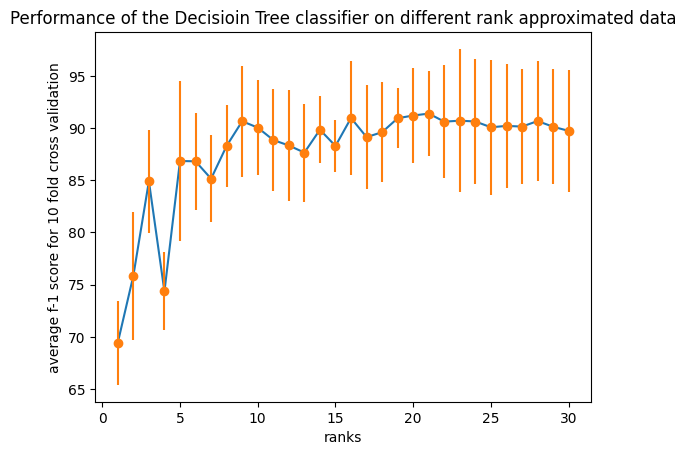

In [ ]:
x_axis = []
y_axis = []
y_err = []
# extract data from accuracy dictionary onto the axis
for index in range (n_features):
  x_axis.append(index + 1)
  y_axis.append(SVD_mean_DT_dict[index + 1] * 100)
  y_err.append(SVD_std_DT_dict[index + 1] * 100)
# plot the graph
plt.plot(x_axis,y_axis)
plt.errorbar(x_axis, y_axis, yerr = y_err, fmt ='o')
plt.xlabel("ranks")
plt.ylabel("average f-1 score for 10 fold cross validation")
plt.title("Performance of the Decisioin Tree classifier on different rank approximated data")
plt.show()

####For Naive Bayes Classifier:

In [ ]:
# a dictionary to store accuracy (mean/std of f1 score) of NB classifier on approaximated dataset from each rank
# key: rank, value: accuracy
SVD_mean_NB_dict = {}
SVD_std_NB_dict = {}
n_samples, n_features = X.shape
# we have added a SVD option into our cross validation function
# we pass in the rank, and it will approximate the training data based on the rank
for index in range (n_features):
  # get current rank, start from 30 to 1
  curr_rank = n_features - index
  SVD_NB = CrossValidation("NB", 10, SVD = True, rank = curr_rank)
  SVD_NB.get_f1_scores(X, y)
  # test using our testing dataset and record accuracy
  SVD_mean_NB = SVD_NB.get_mean()
  SVD_std_NB = SVD_NB.get_std()
  # store the accuracy
  SVD_mean_NB_dict[n_features - index] = SVD_mean_NB
  SVD_std_NB_dict[n_features - index] = SVD_std_NB

size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
Evaluating using approximated data of rank:  30
current f1 score:  0.9545454545454546
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
Evaluating using approximated data of rank:  30
current f1 score:  0.9047619047619048
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
Evaluating using approximated data of rank:  30
current f1 score:  0.9523809523809523
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
Evaluating using approximated data of rank:  30
current f1 score:  0.9545454545454545
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
Evaluating using approximated data of rank:  30
current f1 score:  0.9523809523809523
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
Evaluating using approximated data o

Plot the performance of the Naive Bayes classifier as a function of the SVD approximation rank

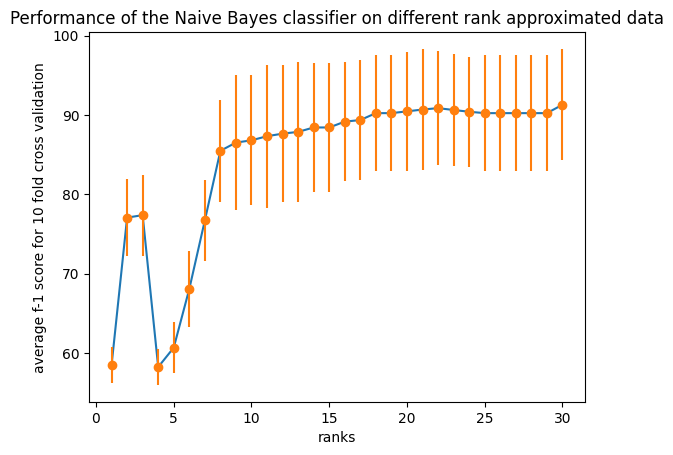

In [ ]:
x_axis = []
y_axis = []
y_err = []
# extract data from accuracy dictionary onto the axis
for index in range (n_features):
  x_axis.append(index + 1)
  y_axis.append(SVD_mean_NB_dict[index + 1] * 100)
  y_err.append(SVD_std_NB_dict[index + 1] * 100)
# plot the graph
plt.plot(x_axis,y_axis)
plt.errorbar(x_axis, y_axis, yerr = y_err, fmt ='o')
plt.xlabel("ranks")
plt.ylabel("average f-1 score for 10 fold cross validation")
plt.title("Performance of the Naive Bayes classifier on different rank approximated data")
plt.show()

##3. Feature selection with randomization [15pts]

In this section, we will implement the feature selection technique which randomizes each feature of the data and measures how predictive it is for our task.\
Knowing that we should conduct feature selection on the 20% of stratified ramdom sample of entire dataset, the main feature selection function will be put into our built cross validation function (thus we can call 5 fold, and perform feature selection after data is splited).\
The high level idea is:\
Basically described all into mini tasks. We will loop through all features, for each of feature, generate a copy of the 20% training dataset, one kept unchanged and the other one have randomized value under current feature. Train two models with these two pieces of datasets, find their average f-1 scores and compare the scores to find the amount of decrease. That decrease should be stored and can be used to find the features that are more/less important.

###Work through example

Split the data, this time, we want 20 percent as training data and 80 percent as testing data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
print("size check: X_train: ", X_train.shape, " y_train: ", y_train.shape, " X_test: ", X_test.shape, " y_test: ", y_test.shape)

size check: X_train:  (113, 31)  y_train:  (113, 1)  X_test:  (456, 31)  y_test:  (456, 1)


In [ ]:
# make a copy of the training dataset
X_train_mutate = X_train

Prior permutation

In [ ]:
X_train_mutate

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,0
62,12.180,22.15,96.42,645.7,0.10490,0.20080,0.21350,0.086530,0.1949,0.07292,...,29.51,119.10,959.5,0.1640,0.6247,0.69220,0.17850,0.2844,0.11320,14.58
457,13.210,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.020680,0.1619,0.05584,...,34.23,91.29,632.9,0.1289,0.1063,0.13900,0.06005,0.2444,0.06788,NaN
182,15.700,20.31,101.20,766.6,0.09597,0.08799,0.06593,0.051890,0.1618,0.05549,...,32.82,129.30,1269.0,0.1414,0.3547,0.29020,0.15410,0.3437,0.08631,NaN
161,19.190,15.94,126.30,1157.0,0.08694,0.11850,0.11930,0.096670,0.1741,0.05176,...,17.81,146.60,1495.0,0.1124,0.2016,0.22640,0.17770,0.2443,0.06251,NaN
124,13.370,16.39,86.10,553.5,0.07115,0.07325,0.08092,0.028000,0.1422,0.05823,...,22.75,91.99,632.1,0.1025,0.2531,0.33080,0.08978,0.2048,0.07628,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,9.876,14.26,102.50,704.4,0.10730,0.21350,0.20770,0.097560,0.2521,0.07032,...,19.08,125.10,980.9,0.1390,0.5954,0.63050,0.23930,0.4667,0.09946,11.45
215,13.860,16.93,90.96,578.9,0.10260,0.15170,0.09901,0.056020,0.2106,0.06916,...,26.93,104.40,750.1,0.1460,0.4370,0.46360,0.16540,0.3630,0.10590,NaN
342,11.060,14.96,71.49,373.9,0.10330,0.09097,0.05397,0.033410,0.1776,0.06907,...,19.90,79.76,440.0,0.1418,0.2210,0.22990,0.10750,0.3301,0.09080,NaN
144,10.750,14.97,68.26,355.3,0.07793,0.05139,0.02251,0.007875,0.1399,0.05688,...,20.72,77.79,441.2,0.1076,0.1223,0.09755,0.03413,0.2300,0.06769,NaN


In [ ]:
# say current feature index is 0
# we will first collect all values of column
feature_index = 0
n_samples, n_features = X_train_mutate.shape
column_val_list = []
for index in range(n_samples):
  column_val_list.append(X_train_mutate.iloc[index, feature_index])
# using existing np library to permutate the values in the column
# reference to: https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html
column_val_list = np.random.permutation(100000)
# update the values in the dataset with new column values
for index in range(n_samples):
  X_train_mutate.iloc[index, feature_index] = column_val_list[index]

In [ ]:
X_train

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,0
62,30012.0,22.15,96.42,645.7,0.10490,0.20080,0.21350,0.086530,0.1949,0.07292,...,29.51,119.10,959.5,0.1640,0.6247,0.69220,0.17850,0.2844,0.11320,14.58
457,9480.0,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.020680,0.1619,0.05584,...,34.23,91.29,632.9,0.1289,0.1063,0.13900,0.06005,0.2444,0.06788,NaN
182,68529.0,20.31,101.20,766.6,0.09597,0.08799,0.06593,0.051890,0.1618,0.05549,...,32.82,129.30,1269.0,0.1414,0.3547,0.29020,0.15410,0.3437,0.08631,NaN
161,30550.0,15.94,126.30,1157.0,0.08694,0.11850,0.11930,0.096670,0.1741,0.05176,...,17.81,146.60,1495.0,0.1124,0.2016,0.22640,0.17770,0.2443,0.06251,NaN
124,73960.0,16.39,86.10,553.5,0.07115,0.07325,0.08092,0.028000,0.1422,0.05823,...,22.75,91.99,632.1,0.1025,0.2531,0.33080,0.08978,0.2048,0.07628,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,71431.0,14.26,102.50,704.4,0.10730,0.21350,0.20770,0.097560,0.2521,0.07032,...,19.08,125.10,980.9,0.1390,0.5954,0.63050,0.23930,0.4667,0.09946,11.45
215,98026.0,16.93,90.96,578.9,0.10260,0.15170,0.09901,0.056020,0.2106,0.06916,...,26.93,104.40,750.1,0.1460,0.4370,0.46360,0.16540,0.3630,0.10590,NaN
342,96336.0,14.96,71.49,373.9,0.10330,0.09097,0.05397,0.033410,0.1776,0.06907,...,19.90,79.76,440.0,0.1418,0.2210,0.22990,0.10750,0.3301,0.09080,NaN
144,10235.0,14.97,68.26,355.3,0.07793,0.05139,0.02251,0.007875,0.1399,0.05688,...,20.72,77.79,441.2,0.1076,0.1223,0.09755,0.03413,0.2300,0.06769,NaN


Run the two datasets on our classifier (we will be using NB here), and compare their mean f-1 score.

###Plots and implementation

The main function of feature selection is implemented into our CrossValidation function.\
According to Professor's email, I choose to randomize the whole training/testing dataset each time for the selected feature.

In [ ]:
# some noticable changes:
'''
if self.feat_select == True:
  # make a copy of X
  X_mutate = X.copy()
  # randomly permutate the column corresponding to current feature_index
  X_mutate = self.random_permutation(X_mutate)
  X_test_mutate, X_train_mutate = X_mutate.iloc[train_index], X_mutate.iloc[test_index]
  # in feature selection, our training/test amount should be reversed
  # say for 5 fold, we should use 20% training data and 80% testing data
  X_test, X_train = X.iloc[train_index], X.iloc[test_index]
  y_test, y_train = y.iloc[train_index], y.iloc[test_index]
'''
'''
# if feat_select is True, then we need to do one additional calculation of f1_scores
  # based on our mutated dataset
  # training of second model
  if self.feat_select == True:
    classifier.fit(X_train_mutate, y_train)
    # get the predicted label list and actual label list
    predicted_labels = classifier.get_predicted_labels(X_test_mutate, y_test)
    actual_labels = classifier.get_true_labels(X_test_mutate, y_test)
    # f1 score will only take in integers, so we need to preprocess the two label lists
    # doesn't really matter which is which
    predicted_labels = [0 if label == 'B' else 1 for label in predicted_labels]
    actual_labels = [0 if label == 'B' else 1 for label in actual_labels]
    # get the current f1 score using f1 calculating function
    score = f1_score(predicted_labels, actual_labels)
    f1_scores_mutate.append(score)
    print("current f1 mutate score: ", score)
'''
'''
  # helper function, using existing np library to randomly mutate the
  # column of feat_index in X_train_mutate
  def random_permutation(self, X_train_mutate):
    feature_index = self.feat_index
    n_samples, n_features = X_train_mutate.shape
    column_val_list = []
    for index in range(n_samples):
      column_val_list.append(X_train_mutate.iloc[index, feature_index])
    # using existing np library to permutate the values in the column
    # reference to: https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html
    # I am assigning extreme numbers to make sure these randomization take affect
    column_val_list = np.random.permutation(100000)
    #column_val_list = np.random.permutation(column_val_list)
    # update the values in the dataset with new column values
    for index in range(n_samples):
      X_train_mutate.iloc[index, feature_index] = column_val_list[index]
    return X_train_mutate
'''

####For Decision Tree Classifier (graph inside)

In [ ]:
# get number of features, we will work through them one by one
n_samples, n_features = X.shape
# a dictionary, key: feature index, value: difference of f1 mean original dataset - difference of f1 mean mutated dataset
# the higher the difference, the more important that feature is
feature_importance_mean_DT = {}
feature_importance_std_DT = {}
for feature_index in range(n_features):
  FS_CV_DT = CrossValidation("DT", 5, feat_select = True, feat_index = feature_index)
  FS_CV_DT.get_f1_scores(X,y)
  feature_difference_mean = FS_CV_DT.get_mean_diff()
  feature_importance_mean_DT[feature_index] = feature_difference_mean
  feature_difference_std = FS_CV_DT.get_std_diff()
  feature_importance_std_DT[feature_index] = feature_difference_std

size check: X_train:  (114, 30)  y_train:  (114, 1)  X_test:  (455, 30)  y_test:  (455, 1)
finished building the tree
current f1 score:  0.874251497005988
finished building the tree
current f1 mutate score:  0.8571428571428571
size check: X_train:  (114, 30)  y_train:  (114, 1)  X_test:  (455, 30)  y_test:  (455, 1)
finished building the tree
current f1 score:  0.8369565217391305
finished building the tree
current f1 mutate score:  0.8356545961002786
size check: X_train:  (114, 30)  y_train:  (114, 1)  X_test:  (455, 30)  y_test:  (455, 1)
finished building the tree
current f1 score:  0.8863636363636362
finished building the tree
current f1 mutate score:  0.8959537572254335
size check: X_train:  (114, 30)  y_train:  (114, 1)  X_test:  (455, 30)  y_test:  (455, 1)
finished building the tree
current f1 score:  0.884012539184953
finished building the tree
current f1 mutate score:  0.8653846153846154
size check: X_train:  (113, 30)  y_train:  (113, 1)  X_test:  (456, 30)  y_test:  (456, 1)

 bar chart that shows each feature and the calculated importance\
 Because there are negative values, thus we can preprocess through the dictionary, finish the least important feature and its value, then add this value to all the other values to keep all values non-negative, this should not change the overall feature importance/result.

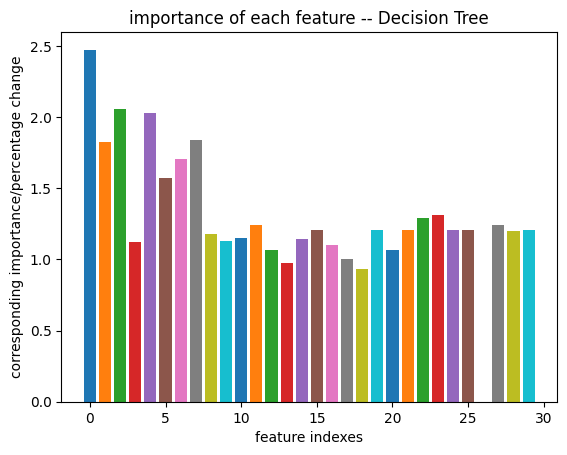

In [ ]:
# simply set to 1, because result is a percentage of maximum 1, difference will never exceed 1
min_percentage = 1
# find the minimum percentage
for feature_index in range(n_features):
  if feature_importance_mean_DT[feature_index] < min_percentage:
    min_percentage = feature_importance_mean_DT[feature_index]
# add this minimum percertage into all the the other feature importance values
for feature_index in range(n_features):
  feature_importance_mean_DT[feature_index] -= min_percentage

# plot the graph, without std values
for feature_index in range(n_features):
  plt.bar(feature_index, feature_importance_mean_DT[feature_index] * 100)
  #plt.bar(feature_index, feature_importance_mean_DT[feature_index] * 100, yerr = abs(feature_importance_std_DT[feature_index]) * 100, capsize = 4)
plt.xlabel("feature indexes")
plt.ylabel("corresponding importance/percentage change")
plt.title("importance of each feature -- Decision Tree")
plt.show()

In [ ]:
# sort by value, reference to: https://realpython.com/sort-python-dictionary/
feature_rank_DT = dict(sorted(feature_importance_mean_DT.items(), key=lambda item: item[1], reverse = True))
print("The top 10 important features are: ")
feature_rank_DT_keys = list(feature_rank_DT.keys())
for i in range (10):
  print(feature_list[feature_rank_DT_keys[i]])

The top 10 important features are: 
radius1
perimeter1
smoothness1
concave_points1
texture1
concavity1
compactness1
area3
perimeter3
texture2


We will now create a dataset only containing these 10 features, put this dataset into our classifiers and measure their performance

In [ ]:
# create the new dataset
# get the top 10 feature's indexes
top_features = []
for i in range (10):
  top_features.append(feature_rank_DT_keys[i])
# get a copy of original dataset X
X_new = X.copy()
# create a new dataset, with only columns equal to first 10 integer in feature_rank_DT_keys
X_new = X_new.iloc[:, top_features]
X_new

,radius1,perimeter1,smoothness1,concave_points1,texture1,concavity1,compactness1,area3,perimeter3,texture2
0,17.99,122.80,0.11840,0.14710,10.38,0.30010,0.27760,2019.0,184.60,0.9053
1,20.57,132.90,0.08474,0.07017,17.77,0.08690,0.07864,1956.0,158.80,0.7339
2,19.69,130.00,0.10960,0.12790,21.25,0.19740,0.15990,1709.0,152.50,0.7869
3,11.42,77.58,0.14250,0.10520,20.38,0.24140,0.28390,567.7,98.87,1.1560
4,20.29,135.10,0.10030,0.10430,14.34,0.19800,0.13280,1575.0,152.20,0.7813
...,...,...,...,...,...,...,...,...,...,...
564,21.56,142.00,0.11100,0.13890,22.39,0.24390,0.11590,2027.0,166.10,1.2560
565,20.13,131.20,0.09780,0.09791,28.25,0.14400,0.10340,1731.0,155.00,2.4630
566,16.60,108.30,0.08455,0.05302,28.08,0.09251,0.10230,1124.0,126.70,1.0750
567,20.60,140.10,0.11780,0.15200,29.33,0.35140,0.27700,1821.0,184.60,1.5950


Get the performances for each classifier with each dataset

In [ ]:
# decision tree
CV_DT = CrossValidation("DT", 10)
f1_scores_DT_old = CV_DT.get_f1_scores(X, y)
DT_f1_mean_old = CV_DT.get_mean()
DT_f1_std_old = CV_DT.get_std()
f1_scores_DT_new = CV_DT.get_f1_scores(X_new, y)
DT_f1_mean_new = CV_DT.get_mean()
DT_f1_std_new = CV_DT.get_std()

size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.9545454545454546
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.9565217391304348
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.975609756097561
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.8947368421052632
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.8837209302325582
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.9500000000000001
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_tes

In [ ]:
# naive bayes
CV_NB = CrossValidation("NB", 10)
f1_scores_NB_old = CV_NB.get_f1_scores(X, y)
NB_f1_mean_old = CV_NB.get_mean()
NB_f1_std_old = CV_NB.get_std()
f1_scores_NB_new = CV_NB.get_f1_scores(X_new, y)
NB_f1_mean_new = CV_NB.get_mean()
NB_f1_std_new = CV_NB.get_std()

size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9767441860465117
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9333333333333332
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9047619047619048
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8421052631578947
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9268292682926829
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8648648648648648
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8837209302325582
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8

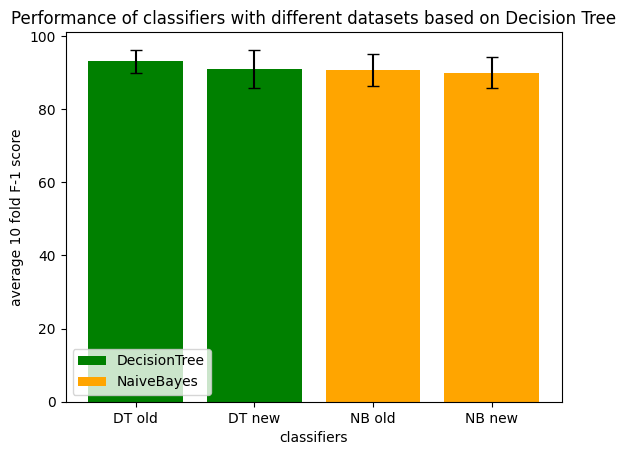

In [ ]:
# plot the graphs
plt.bar("DT old", DT_f1_mean_old * 100, yerr = DT_f1_std_old * 100, color = "green", capsize = 4, label = "DecisionTree")
plt.bar("DT new", DT_f1_mean_new * 100, yerr = DT_f1_std_new * 100, color = "green", capsize = 4)
plt.bar("NB old", NB_f1_mean_old * 100, yerr = NB_f1_std_old * 100, color = "orange", capsize = 4, label = "NaiveBayes")
plt.bar("NB new", NB_f1_mean_new * 100, yerr = NB_f1_std_new * 100, color = "orange", capsize = 4)
plt.xlabel("classifiers")
plt.ylabel("average 10 fold F-1 score")
plt.title("Performance of classifiers with different datasets based on Decision Tree")
plt.legend()
plt.show()

####For Naive Bayes Classifier (graph inside)

In [ ]:
# get number of features, we will work through them one by one
n_samples, n_features = X.shape
# a dictionary, key: feature index, value: difference of f1 mean original dataset - difference of f1 mean mutated dataset
# the higher the difference, the more important that feature is
feature_importance_mean_NB = {}
feature_importance_std_NB = {}
for feature_index in range(n_features):
  FS_CV_NB = CrossValidation("NB", 5, feat_select = True, feat_index = feature_index)
  FS_CV_NB.get_f1_scores(X,y)
  feature_difference_mean = FS_CV_NB.get_mean_diff()
  feature_importance_mean_NB[feature_index] = feature_difference_mean
  feature_difference_std = FS_CV_NB.get_std_diff()
  feature_importance_std_NB[feature_index] = feature_difference_std

size check: X_train:  (114, 30)  y_train:  (114, 1)  X_test:  (455, 30)  y_test:  (455, 1)
current f1 score:  0.896969696969697
current f1 mutate score:  0.896969696969697
size check: X_train:  (114, 30)  y_train:  (114, 1)  X_test:  (455, 30)  y_test:  (455, 1)
current f1 score:  0.9257142857142856
current f1 mutate score:  0.9310344827586208
size check: X_train:  (114, 30)  y_train:  (114, 1)  X_test:  (455, 30)  y_test:  (455, 1)
current f1 score:  0.8939828080229225
current f1 mutate score:  0.8850574712643678
size check: X_train:  (114, 30)  y_train:  (114, 1)  X_test:  (455, 30)  y_test:  (455, 1)
current f1 score:  0.9216300940438872
current f1 mutate score:  0.9278996865203762
size check: X_train:  (113, 30)  y_train:  (113, 1)  X_test:  (456, 30)  y_test:  (456, 1)
current f1 score:  0.9047619047619048
current f1 mutate score:  0.9047619047619048
size check: X_train:  (114, 30)  y_train:  (114, 1)  X_test:  (455, 30)  y_test:  (455, 1)
current f1 score:  0.896969696969697
curr

bar chart that shows each feature and the calculated importance
Because there are negative values, thus we can preprocess through the dictionary, finish the least important feature and its value, then add this value to all the other values to keep all values non-negative, this should not change the overall feature importance/result.

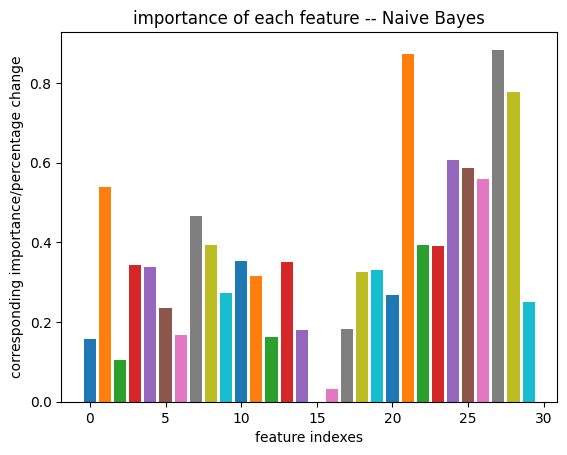

In [ ]:
# simply set to 1, because result is a percentage of maximum 1, difference will never exceed 1
min_percentage = 1
# find the minimum percentage
for feature_index in range(n_features):
  if feature_importance_mean_NB[feature_index] < min_percentage:
    min_percentage = feature_importance_mean_NB[feature_index]
# add this minimum percertage into all the the other feature importance values
for feature_index in range(n_features):
  feature_importance_mean_NB[feature_index] -= min_percentage

# plot the graph, without std values
for feature_index in range(n_features):
  plt.bar(feature_index, feature_importance_mean_NB[feature_index] * 100)
  #plt.bar(feature_index, feature_importance_mean_NB[feature_index] * 100, yerr = abs(feature_importance_std_NB[feature_index]) * 100, capsize = 4)
plt.xlabel("feature indexes")
plt.ylabel("corresponding importance/percentage change")
plt.title("importance of each feature -- Naive Bayes")
plt.show()

In [ ]:
# sort by value, reference to: https://realpython.com/sort-python-dictionary/
feature_rank_NB = dict(sorted(feature_importance_mean_NB.items(), key=lambda item: item[1], reverse = True))
print("The top 10 important features are: ")
feature_rank_NB_keys = list(feature_rank_NB.keys())
for i in range (10):
  print(feature_list[feature_rank_NB_keys[i]])

The top 10 important features are: 
concave_points3
texture3
symmetry3
smoothness3
compactness3
concavity3
texture1
concave_points1
perimeter3
symmetry1


We will now create a dataset only containing these 10 features, put this dataset into our classifiers and measure their performance

In [ ]:
# create the new dataset
# get the top 10 feature's indexes
top_features = []
for i in range (10):
  top_features.append(feature_rank_NB_keys[i])
# get a copy of original dataset X
X_new = X.copy()
# create a new dataset, with only columns equal to first 10 integer in feature_rank_DT_keys
X_new = X_new.iloc[:, top_features]
X_new

,concave_points3,texture3,symmetry3,smoothness3,compactness3,concavity3,texture1,concave_points1,perimeter3,symmetry1
0,0.2654,17.33,0.4601,0.16220,0.66560,0.7119,10.38,0.14710,184.60,0.2419
1,0.1860,23.41,0.2750,0.12380,0.18660,0.2416,17.77,0.07017,158.80,0.1812
2,0.2430,25.53,0.3613,0.14440,0.42450,0.4504,21.25,0.12790,152.50,0.2069
3,0.2575,26.50,0.6638,0.20980,0.86630,0.6869,20.38,0.10520,98.87,0.2597
4,0.1625,16.67,0.2364,0.13740,0.20500,0.4000,14.34,0.10430,152.20,0.1809
...,...,...,...,...,...,...,...,...,...,...
564,0.2216,26.40,0.2060,0.14100,0.21130,0.4107,22.39,0.13890,166.10,0.1726
565,0.1628,38.25,0.2572,0.11660,0.19220,0.3215,28.25,0.09791,155.00,0.1752
566,0.1418,34.12,0.2218,0.11390,0.30940,0.3403,28.08,0.05302,126.70,0.1590
567,0.2650,39.42,0.4087,0.16500,0.86810,0.9387,29.33,0.15200,184.60,0.2397


In [ ]:
# decision tree
CV_DT = CrossValidation("DT", 10)
f1_scores_DT_old = CV_DT.get_f1_scores(X, y)
DT_f1_mean_old = CV_DT.get_mean()
DT_f1_std_old = CV_DT.get_std()
f1_scores_DT_new = CV_DT.get_f1_scores(X_new, y)
DT_f1_mean_new = CV_DT.get_mean()
DT_f1_std_new = CV_DT.get_std()

size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.9545454545454546
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.9565217391304348
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.975609756097561
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.8947368421052632
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.8837209302325582
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.9500000000000001
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_tes

In [ ]:
# naive bayes
CV_NB = CrossValidation("NB", 10)
f1_scores_NB_old = CV_NB.get_f1_scores(X, y)
NB_f1_mean_old = CV_NB.get_mean()
NB_f1_std_old = CV_NB.get_std()
f1_scores_NB_new = CV_NB.get_f1_scores(X_new, y)
NB_f1_mean_new = CV_NB.get_mean()
NB_f1_std_new = CV_NB.get_std()

size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9767441860465117
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9333333333333332
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9047619047619048
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8421052631578947
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9268292682926829
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8648648648648648
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8837209302325582
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8

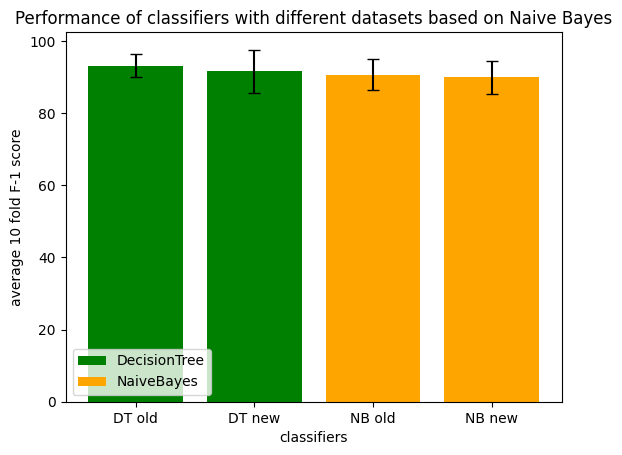

In [ ]:
# plot the graphs
plt.bar("DT old", DT_f1_mean_old * 100, yerr = DT_f1_std_old * 100, color = "green", capsize = 4, label = "DecisionTree")
plt.bar("DT new", DT_f1_mean_new * 100, yerr = DT_f1_std_new * 100, color = "green", capsize = 4)
plt.bar("NB old", NB_f1_mean_old * 100, yerr = NB_f1_std_old * 100, color = "orange", capsize = 4, label = "NaiveBayes")
plt.bar("NB new", NB_f1_mean_new * 100, yerr = NB_f1_std_new * 100, color = "orange", capsize = 4)
plt.xlabel("classifiers")
plt.ylabel("average 10 fold F-1 score")
plt.title("Performance of classifiers with different datasets based on Naive Bayes")
plt.legend()
plt.show()

##4. Data augmentation using SMOTE [10pts]

SMOTE is one of the earliest and very successful data augmentation (or minority class oversampling) techniques. In this section, we will try to implement SMOTE and apply this technique to our classifiers\
My code is referenced to the pesudocode presented in the SMOTE paper: https://arxiv.org/pdf/1106.1813 \
For K-nearest neighbour functionality, we can use existing library (as mentioned in piazza), the library I will be using is refering to: https://scikit-learn.org/stable/modules/neighbors.html \
High level idea of our algorithm: \
There are two key steps (reference to lecture slide): We will first find the k nearest neighbours of minority class trying examples; next we will generate synthetic data points along the lines.\
The goal is to generate a new dataset with amplified number of minority class samples (depend on input N), we will first get a record of input k and N these are essential input needed. We can get T from input original X and y, all we need to do is to loop through y, find the minority label first, then keep track of the row index with these minority label, lastly, extract the corresponding rows from X and form a new dataset with minority labelled samples only, and this is T.\
We will use existing KNN library to find the list of (k + 1) nearest neighbours for each sample point in T, the reason for k + 1 is because, sklearn's KNN will count in the sample itself as "the cloest neighbour" and that is no use for us, and simply get one more neighbour.\
We can now generate synthetic X and y. Synthetic y is easy to build, we just need to append (N/100 * T) amount of minority labels behind a copy of original y, and there it is, because all the newly generate samples will have label of that minority label. For synthetic X, we need to first randomly pick one of its selected closet neighbours, mensure the distance between the two samples (list of difference value of length column), then pick a gap between 0 and 1, increment each column value of original X by gap times its corresponding difference value. Repeat N/100 times for each sample, and we will have our synthetic X dataset.\
Lastly, we just need to apply the synthetic X and synthetic y into our classifiers and able to measure its performance after the change.

###code implementation

In [ ]:
# import KNN library
from sklearn.neighbors import NearestNeighbors
import random

# cite from paper:
# Input: Number of minority class samples T; Amount of SMOTE N%; Number of nearest neighbors k
# Output: (N/100) * T synthetic minority class samples
# we will assume that we already input valid inputs: N >= 100 and k is valid positive integer

class SMOTE:
  def __init__(self, N = None, k = None):
    # Number of minority class samples T
    # we do not pass in T, we will get dataset X/y, and then we will derive T
    self.T_x = None
    self.T_y = None
    # amount of SMOTE N%
    self.N = N
    # number of nearest neighbors
    self.k = k
    # minority label
    self.min_label = None
    # final synthetic dataset
    self.synthetic_X = None
    self.synthetic_y = None

  # pass in datasets X and y
  def fit(self, X, y):
    # find minority label
    self.min_label = self.find_min_label(y)
    # split data, create new dataset X/y only have minority class samples
    new_X, new_y = self.generate_new_data(X, y)
    # this new dataset X is corresponding to T
    # I have saved y as well for easier processing
    self.T_x = new_X
    self.T_y = new_y
    # Compute k nearest neighbors for each minority class sample
    # save it in a nearest neighbour array
    nnarray = None
    nnarray = self.get_nearest_neighbours()
    # create new dataset
    # make a copy of dataset X and dataset y
    X_copy = X.copy()
    y_copy = y.copy()
    self.get_synthetic_dataset(X_copy, y_copy, nnarray)

  # helper function to get the syn
  def get_synthetic_dataset(self, X_copy, y_copy, nnarray):
    new_X = self.T_x
    # get number of samples
    n_samples, n_features = new_X.shape
    new_y = self.T_y
    # get number of copies, 100% => 1 copy
    num_copy = self.N / 100
    # we will process y first, it is easier
    # we just push copy number of y_new under y_copy, because all new samples will result in this minority label
    # reference of cancat: https://pandas.pydata.org/docs/reference/api/pandas.concat.html
    # convert to int since float cannot be iterated
    for i in range(int(num_copy)):
      y_copy = y_copy._append(new_y, ignore_index = True)
    # process through each minority sample
    for index in range(n_samples):
      # process num of copy times
      for i in range(int(num_copy)):
        # get the list of current sample's nearest neighbours, excluding itself of course
        curr_nn_list = nnarray[0][1:]
        # pick a random sample from the list
        # reference to: https://stackoverflow.com/questions/306400/how-can-i-randomly-select-choose-an-item-from-a-list-get-a-random-element
        # for randomly choose a integer from the list
        chosen_index = random.choice(curr_nn_list)
        # get the difference of each column between current row and chosen row
        differences_list = self.get_difference(n_features, new_X.iloc[index], new_X.iloc[chosen_index])
        # generate a number between 0 and 1
        # reference to: https://stackoverflow.com/questions/33359740/random-number-between-0-and-1
        gap = random.random()
        # make a copy of current row
        new_row = new_X.iloc[index].copy()
        # increment each feature value by gap * difference we previous get
        for j in range(n_features):
          new_row[j] += gap * differences_list[j]
        # append the newly create sample to the copy of X dataset
        X_copy = X_copy._append(new_row, ignore_index = True)
    # save the modified new datasets: X and y copy
    self.synthetic_X = X_copy
    self.synthetic_y = y_copy

  # helper function
  # extract the generate new datasets
  def get_dataset(self):
    return self.synthetic_X, self.synthetic_y

  # helper function
  # generate a difference list for each feature between current row and chosen row
  def get_difference(self, n_features, curr_row, target_row):
    differences_list = []
    # loop through each column
    for i in range (n_features):
      # get the difference and append into list
      differences_list.append(target_row[i] - curr_row[i])
    return differences_list

  # helper function
  # for each sample index (of minority class), find its k nearest neighbours
  # we will be using exisiting library to perform KNN
  def get_nearest_neighbours(self):
    # reference to https://scikit-learn.org/stable/modules/neighbors.html
    # after testing, if we only input k (say k = 1, then the closet neighbour is index itself), it includes inself and is no use for us, we need k + 1
    neighbours = NearestNeighbors(n_neighbors = self.k + 1, metric='euclidean', algorithm = 'ball_tree').fit(self.T_x)
    distances, nnarray = neighbours.kneighbors(self.T_x)
    print("nn array shape: ", nnarray.shape)
    #print("first line: ", nnarray[0])
    #print("first line without itself: ", nnarray[0][1:])
    return nnarray

  # helper function, given that we have found the minority label
  # derive new datasets with label equals to the minority label only
  # reference: https://www.geeksforgeeks.org/how-to-add-one-row-in-an-existing-pandas-dataframe/
  def generate_new_data(self, X, y):
    # extract the minority label
    target_label = self.min_label
    # for testing purpose
    # target_label = 'M'
    # generate new dataframe
    new_X = pd.DataFrame()
    new_y = pd.DataFrame()
    n_samples, _ = X.shape
    # loop through every row in X
    # keep track of the current row number
    index = 0
    for index in range(n_samples):
      # if the current row's corresponding label is a minority label
      if(y.iloc[index, 0] == target_label):
        # current row is selected
        new_X = new_X._append(X.iloc[index], ignore_index = True)
        new_y = new_y._append(y.iloc[index], ignore_index = True)
    return new_X, new_y

  # helper function to get the minority label
  # and return the label that appear the least
  def find_min_label(self, y):
    # number of unique labels from y
    unique_labels = np.unique(y)
    # set a maximum value
    min_hit = float("inf")
    selected_label = None
    # record the label that appears the least times
    for label in unique_labels:
      curr_hit = 0
      for index in range(len(y)):
        # we know that y have only 1 column
        if(y.iloc[index, 0] == label):
          curr_hit = curr_hit + 1
      # check number of occurance of current label
      if curr_hit < min_hit:
        # update min hit
        min_hit = curr_hit
        selected_label = label
    return selected_label

###For Decision Tree Classifier (graph inside)

####original dataset

In [ ]:
CV_DT = CrossValidation("DT", 10)
DT_0 = CV_DT.get_f1_scores(X, y)
DT_0_mean = CV_DT.get_mean()
DT_0_std = CV_DT.get_std()
DT_0_mean

size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.9545454545454546
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.9565217391304348
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.975609756097561
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.8947368421052632
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.8837209302325582
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
finished building the tree
current f1 score:  0.9500000000000001
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_tes

0.931480249619765

####For N = 100 and k = 1

In [ ]:
SM = SMOTE(N = 100, k = 1)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

nn array shape:  (212, 2)


verification step

In [ ]:
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (781, 30)  synthetic_y shape:  (781, 1)
original M count:  212  original B count:  357
synthetic M count:  424  synthetic B count:  357


Call Decision Tree classifier and get the accuracy

In [ ]:
CV_DT = CrossValidation("DT", 10)
DT_100_1 = CV_DT.get_f1_scores(synthetic_X, synthetic_y)
DT_100_1_mean = CV_DT.get_mean()
DT_100_1_std = CV_DT.get_std()
DT_100_1_mean

size check: X_train:  (702, 30)  y_train:  (702, 1)  X_test:  (79, 30)  y_test:  (79, 1)
finished building the tree
current f1 score:  0.9647058823529412
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
finished building the tree
current f1 score:  0.963855421686747
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
finished building the tree
current f1 score:  0.9545454545454545
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
finished building the tree
current f1 score:  0.9772727272727273
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
finished building the tree
current f1 score:  0.9302325581395349
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
finished building the tree
current f1 score:  0.9425287356321839
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_tes

0.9533374338736726

####For N = 200 and k = 1

In [ ]:
# call smote and get new dataset
SM = SMOTE(N = 200, k = 1)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

# check if the new dataset make sense
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

# get current classifier's performance on generated dataset
CV_DT = CrossValidation("DT", 10)
DT_200_1 = CV_DT.get_f1_scores(synthetic_X, synthetic_y)
DT_200_1_mean = CV_DT.get_mean()
DT_200_1_std = CV_DT.get_std()

nn array shape:  (212, 2)
original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (993, 30)  synthetic_y shape:  (993, 1)
original M count:  212  original B count:  357
synthetic M count:  636  synthetic B count:  357
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
finished building the tree
current f1 score:  0.9618320610687023
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
finished building the tree
current f1 score:  0.9523809523809523
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
finished building the tree
current f1 score:  0.9846153846153847
size check: X_train:  (894, 30)  y_train:  (894, 1)  X_test:  (99, 30)  y_test:  (99, 1)
finished building the tree
current f1 score:  0.9538461538461539
size check: X_train:  (894, 30)  y_train:  (894, 1)  X_test:  (99, 30)  y_test:  (99, 1)
finished building the tree
current f1 score:  0.9

####For N = 300 and k = 1

In [ ]:
# call smote and get new dataset
SM = SMOTE(N = 300, k = 1)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

# check if the new dataset make sense
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

# get current classifier's performance on generated dataset
CV_DT = CrossValidation("DT", 10)
DT_300_1 = CV_DT.get_f1_scores(synthetic_X, synthetic_y)
DT_300_1_mean = CV_DT.get_mean()
DT_300_1_std = CV_DT.get_std()

nn array shape:  (212, 2)
original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (1205, 30)  synthetic_y shape:  (1205, 1)
original M count:  212  original B count:  357
synthetic M count:  848  synthetic B count:  357
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
finished building the tree
current f1 score:  0.9767441860465116
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
finished building the tree
current f1 score:  0.9647058823529412
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
finished building the tree
current f1 score:  0.9704142011834319
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
finished building the tree
current f1 score:  0.9659090909090909
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
finished building the tree
curren

####For N = 100 and k = 5

In [ ]:
# call smote and get new dataset
SM = SMOTE(N = 100, k = 5)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

# check if the new dataset make sense
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

# get current classifier's performance on generated dataset
CV_DT = CrossValidation("DT", 10)
DT_100_5 = CV_DT.get_f1_scores(synthetic_X, synthetic_y)
DT_100_5_mean = CV_DT.get_mean()
DT_100_5_std = CV_DT.get_std()

nn array shape:  (212, 6)
original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (781, 30)  synthetic_y shape:  (781, 1)
original M count:  212  original B count:  357
synthetic M count:  424  synthetic B count:  357
size check: X_train:  (702, 30)  y_train:  (702, 1)  X_test:  (79, 30)  y_test:  (79, 1)
finished building the tree
current f1 score:  0.9302325581395349
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
finished building the tree
current f1 score:  0.9534883720930233
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
finished building the tree
current f1 score:  0.9647058823529412
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
finished building the tree
current f1 score:  0.9767441860465116
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
finished building the tree
current f1 score:  0.9761904

####For N = 200 and k = 5

In [ ]:
# call smote and get new dataset
SM = SMOTE(N = 200, k = 5)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

# check if the new dataset make sense
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

# get current classifier's performance on generated dataset
CV_DT = CrossValidation("DT", 10)
DT_200_5 = CV_DT.get_f1_scores(synthetic_X, synthetic_y)
DT_200_5_mean = CV_DT.get_mean()
DT_200_5_std = CV_DT.get_std()

nn array shape:  (212, 6)
original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (993, 30)  synthetic_y shape:  (993, 1)
original M count:  212  original B count:  357
synthetic M count:  636  synthetic B count:  357
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
finished building the tree
current f1 score:  0.9545454545454545
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
finished building the tree
current f1 score:  0.9606299212598425
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
finished building the tree
current f1 score:  0.9922480620155039
size check: X_train:  (894, 30)  y_train:  (894, 1)  X_test:  (99, 30)  y_test:  (99, 1)
finished building the tree
current f1 score:  0.9767441860465116
size check: X_train:  (894, 30)  y_train:  (894, 1)  X_test:  (99, 30)  y_test:  (99, 1)
finished building the tree
current f1 score:  0.9

#### For N = 300 and k = 5

In [ ]:
# call smote and get new dataset
SM = SMOTE(N = 300, k = 5)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

# check if the new dataset make sense
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

# get current classifier's performance on generated dataset
CV_DT = CrossValidation("DT", 10)
DT_300_5 = CV_DT.get_f1_scores(synthetic_X, synthetic_y)
DT_300_5_mean = CV_DT.get_mean()
DT_300_5_std = CV_DT.get_std()

nn array shape:  (212, 6)
original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (1205, 30)  synthetic_y shape:  (1205, 1)
original M count:  212  original B count:  357
synthetic M count:  848  synthetic B count:  357
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
finished building the tree
current f1 score:  0.9883720930232558
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
finished building the tree
current f1 score:  0.9824561403508771
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
finished building the tree
current f1 score:  0.9647058823529412
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
finished building the tree
current f1 score:  0.9767441860465116
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
finished building the tree
curren

####Graph

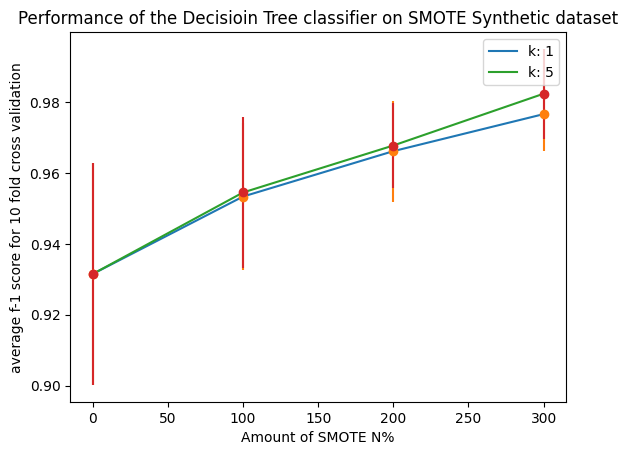

In [ ]:
x_axis = [0, 100, 200, 300]
# for k = 1
y_1_axis = [DT_0_mean, DT_100_1_mean, DT_200_1_mean, DT_300_1_mean]
y_1_err = [DT_0_std, DT_100_1_std, DT_200_1_std, DT_300_1_std]
# for k = 5
y_5_axis = [DT_0_mean, DT_100_5_mean, DT_200_5_mean, DT_300_5_mean]
y_5_err = [DT_0_std, DT_100_5_std, DT_200_5_std, DT_300_5_std]
# plot the graph
plt.plot(x_axis,y_1_axis, label = "k: 1")
plt.errorbar(x_axis, y_1_axis, yerr = y_1_err, fmt ='o')
plt.plot(x_axis,y_5_axis, label = "k: 5")
plt.errorbar(x_axis, y_5_axis, yerr = y_5_err, fmt ='o')
plt.xlabel("Amount of SMOTE N%")
plt.ylabel("average f-1 score for 10 fold cross validation")
plt.title("Performance of the Decisioin Tree classifier on SMOTE Synthetic dataset")
plt.legend()
plt.show()

###For Naive Bayes Classifier (graph inside)

####original dataset

In [ ]:
CV_NB = CrossValidation("NB", 10)
NB_0 = CV_NB.get_f1_scores(X, y)
NB_0_mean = CV_NB.get_mean()
NB_0_std = CV_NB.get_std()
NB_0_mean

size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9767441860465117
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9333333333333332
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9047619047619048
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8421052631578947
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.9268292682926829
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8648648648648648
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8837209302325582
size check: X_train:  (512, 30)  y_train:  (512, 1)  X_test:  (57, 30)  y_test:  (57, 1)
current f1 score:  0.8

0.9061018287275118

####For N = 100 and k = 1

In [ ]:
# call smote and get new dataset
SM = SMOTE(N = 100, k = 1)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

# check if the new dataset make sense
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

# get current classifier's performance on generated dataset
CV_NB = CrossValidation("NB", 10)
NB_100_1 = CV_NB.get_f1_scores(synthetic_X, synthetic_y)
NB_100_1_mean = CV_NB.get_mean()
NB_100_1_std = CV_NB.get_std()

nn array shape:  (212, 2)
original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (781, 30)  synthetic_y shape:  (781, 1)
original M count:  212  original B count:  357
synthetic M count:  424  synthetic B count:  357
size check: X_train:  (702, 30)  y_train:  (702, 1)  X_test:  (79, 30)  y_test:  (79, 1)
current f1 score:  0.9382716049382717
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
current f1 score:  0.9249999999999999
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
current f1 score:  0.9647058823529412
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
current f1 score:  1.0
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
current f1 score:  0.9397590361445782
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
current f1 score:  0.9534883720930233
size check: X

####For N = 200 and k = 1

In [ ]:
# call smote and get new dataset
SM = SMOTE(N = 200, k = 1)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

# check if the new dataset make sense
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

# get current classifier's performance on generated dataset
CV_NB = CrossValidation("NB", 10)
NB_200_1 = CV_NB.get_f1_scores(synthetic_X, synthetic_y)
NB_200_1_mean = CV_NB.get_mean()
NB_200_1_std = CV_NB.get_std()

nn array shape:  (212, 2)
original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (993, 30)  synthetic_y shape:  (993, 1)
original M count:  212  original B count:  357
synthetic M count:  636  synthetic B count:  357
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
current f1 score:  0.96
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
current f1 score:  0.976
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
current f1 score:  0.9841269841269841
size check: X_train:  (894, 30)  y_train:  (894, 1)  X_test:  (99, 30)  y_test:  (99, 1)
current f1 score:  0.96875
size check: X_train:  (894, 30)  y_train:  (894, 1)  X_test:  (99, 30)  y_test:  (99, 1)
current f1 score:  0.959349593495935
size check: X_train:  (894, 30)  y_train:  (894, 1)  X_test:  (99, 30)  y_test:  (99, 1)
current f1 score:  0.96
size check: X_train:  (894, 30)  y_train:  (8

####For N = 300 and k = 1

In [ ]:
# call smote and get new dataset
SM = SMOTE(N = 300, k = 1)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

# check if the new dataset make sense
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

# get current classifier's performance on generated dataset
CV_NB = CrossValidation("NB", 10)
NB_300_1 = CV_NB.get_f1_scores(synthetic_X, synthetic_y)
NB_300_1_mean = CV_NB.get_mean()
NB_300_1_std = CV_NB.get_std()

nn array shape:  (212, 2)
original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (1205, 30)  synthetic_y shape:  (1205, 1)
original M count:  212  original B count:  357
synthetic M count:  848  synthetic B count:  357
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
current f1 score:  0.9761904761904762
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
current f1 score:  1.0
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
current f1 score:  0.9700598802395209
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
current f1 score:  0.9940828402366864
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
current f1 score:  0.9575757575757576
size check: X_train:  (1085, 30)  y_train:  (1085, 1)  X_test:  (120, 30)  y_test:  (120, 1)
current f1 score:  0.9759

####For N = 100 and k = 5

In [ ]:
# call smote and get new dataset
SM = SMOTE(N = 100, k = 5)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

# check if the new dataset make sense
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

# get current classifier's performance on generated dataset
CV_NB = CrossValidation("NB", 10)
NB_100_5 = CV_NB.get_f1_scores(synthetic_X, synthetic_y)
NB_100_5_mean = CV_NB.get_mean()
NB_100_5_std = CV_NB.get_std()

nn array shape:  (212, 6)
original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (781, 30)  synthetic_y shape:  (781, 1)
original M count:  212  original B count:  357
synthetic M count:  424  synthetic B count:  357
size check: X_train:  (702, 30)  y_train:  (702, 1)  X_test:  (79, 30)  y_test:  (79, 1)
current f1 score:  0.9382716049382717
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
current f1 score:  0.9249999999999999
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
current f1 score:  0.9523809523809524
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
current f1 score:  1.0
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
current f1 score:  0.9397590361445782
size check: X_train:  (703, 30)  y_train:  (703, 1)  X_test:  (78, 30)  y_test:  (78, 1)
current f1 score:  0.9647058823529412
size check: X

####For N = 200 and k = 5

In [ ]:
# call smote and get new dataset
SM = SMOTE(N = 200, k = 5)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

# check if the new dataset make sense
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

# get current classifier's performance on generated dataset
CV_NB = CrossValidation("NB", 10)
NB_200_5 = CV_NB.get_f1_scores(synthetic_X, synthetic_y)
NB_200_5_mean = CV_NB.get_mean()
NB_200_5_std = CV_NB.get_std()

nn array shape:  (212, 6)
original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (993, 30)  synthetic_y shape:  (993, 1)
original M count:  212  original B count:  357
synthetic M count:  636  synthetic B count:  357
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
current f1 score:  0.96
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
current f1 score:  0.9841269841269841
size check: X_train:  (893, 30)  y_train:  (893, 1)  X_test:  (100, 30)  y_test:  (100, 1)
current f1 score:  0.9921259842519685
size check: X_train:  (894, 30)  y_train:  (894, 1)  X_test:  (99, 30)  y_test:  (99, 1)
current f1 score:  0.96875
size check: X_train:  (894, 30)  y_train:  (894, 1)  X_test:  (99, 30)  y_test:  (99, 1)
current f1 score:  0.9508196721311475
size check: X_train:  (894, 30)  y_train:  (894, 1)  X_test:  (99, 30)  y_test:  (99, 1)
current f1 score:  0.9682539682539683
size check: X_tra

####For N = 300 and k = 5

In [ ]:
# call smote and get new dataset
SM = SMOTE(N = 300, k = 5)
SM.fit(X, y)
synthetic_X, synthetic_y = SM.get_dataset()

# check if the new dataset make sense
ori_M_count = 0
ori_B_count = 0
for i in range(len(y)):
  if(y.iloc[i,0] == 'B'):
    ori_B_count = ori_B_count + 1
  if(y.iloc[i,0] == 'M'):
    ori_M_count = ori_M_count + 1
syn_M_count = 0
syn_B_count = 0
for i in range(len(synthetic_y)):
  if(synthetic_y.iloc[i,0] == 'B'):
    syn_B_count = syn_B_count + 1
  if(synthetic_y.iloc[i,0] == 'M'):
    syn_M_count = syn_M_count + 1
print("original X shape: ", X.shape, " original y shape: ", y.shape)
print("synthetic X shape: ", synthetic_X.shape, " synthetic_y shape: ", synthetic_y.shape)
print("original M count: ", ori_M_count, " original B count: ", ori_B_count)
print("synthetic M count: ", syn_M_count, " synthetic B count: ", syn_B_count)

# get current classifier's performance on generated dataset
CV_NB = CrossValidation("NB", 10)
NB_300_5 = CV_NB.get_f1_scores(synthetic_X, synthetic_y)
NB_300_5_mean = CV_NB.get_mean()
NB_300_5_std = CV_NB.get_std()

nn array shape:  (212, 6)
original X shape:  (569, 30)  original y shape:  (569, 1)
synthetic X shape:  (1205, 30)  synthetic_y shape:  (1205, 1)
original M count:  212  original B count:  357
synthetic M count:  848  synthetic B count:  357
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
current f1 score:  0.988095238095238
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
current f1 score:  0.9822485207100591
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
current f1 score:  0.9761904761904762
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
current f1 score:  0.988095238095238
size check: X_train:  (1084, 30)  y_train:  (1084, 1)  X_test:  (121, 30)  y_test:  (121, 1)
current f1 score:  0.9512195121951219
size check: X_train:  (1085, 30)  y_train:  (1085, 1)  X_test:  (120, 30)  y_test:  (120, 1)
current f1 s

####graph

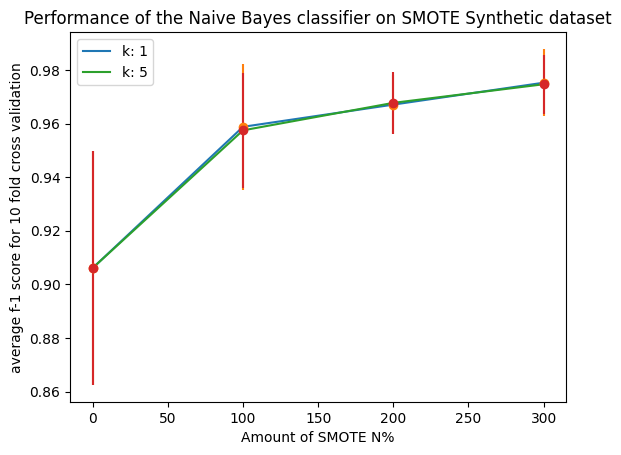

In [ ]:
x_axis = [0, 100, 200, 300]
# for k = 1
y_1_axis = [NB_0_mean, NB_100_1_mean, NB_200_1_mean, NB_300_1_mean]
y_1_err = [NB_0_std, NB_100_1_std, NB_200_1_std, NB_300_1_std]
# for k = 5
y_5_axis = [NB_0_mean, NB_100_5_mean, NB_200_5_mean, NB_300_5_mean]
y_5_err = [NB_0_std, NB_100_5_std, NB_200_5_std, NB_300_5_std]
# plot the graph
plt.plot(x_axis,y_1_axis, label = "k: 1")
plt.errorbar(x_axis, y_1_axis, yerr = y_1_err, fmt ='o')
plt.plot(x_axis,y_5_axis, label = "k: 5")
plt.errorbar(x_axis, y_5_axis, yerr = y_5_err, fmt ='o')
plt.xlabel("Amount of SMOTE N%")
plt.ylabel("average f-1 score for 10 fold cross validation")
plt.title("Performance of the Naive Bayes classifier on SMOTE Synthetic dataset")
plt.legend()
plt.show()

###testing area (disregard)

In [ ]:
SM = SMOTE(N = 100, k = 5)

In [ ]:
min_label = SM.find_min_label(y)
min_label

('M', 212)

In [ ]:
new_X, new_y = SM.generate_new_data(X,y)
new_X

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,...,24.29,29.41,179.10,1819.0,0.1407,0.4186,0.6599,0.2542,0.2929,0.09873
208,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.45,26.40,166.10,2027.0,0.1410,0.2113,0.4107,0.2216,0.2060,0.07115
209,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.69,38.25,155.00,1731.0,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637
210,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.98,34.12,126.70,1124.0,0.1139,0.3094,0.3403,0.1418,0.2218,0.07820


In [ ]:
new_y

,Diagnosis
0,M
1,M
2,M
3,M
4,M
...,...
207,M
208,M
209,M
210,M


In [ ]:
SM.fit(X, y)

nn array shape:  (212, 6)
